# ECE 657 Assignment 1 : Problem 4

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import random
import math
import pickle
import matplotlib.pyplot as plt

In [2]:
# Loading the dataset
X = pd.read_csv('train_data.csv',header=None)
y = pd.read_csv('train_labels.csv',header=None)

In [3]:
# checking the number of features and samples in X and y
X.shape, y.shape

((24754, 784), (24754, 4))

In [4]:
y.head()

0    1    2    3
0  1.0  0.0  0.0  0.0
1  0.0  1.0  0.0  0.0
2  0.0  0.0  1.0  0.0
3  0.0  1.0  0.0  0.0
4  0.0  0.0  0.0  1.0

In [5]:
# Checking how may data points are there in each class [0,1,2,3]
print('Number of data points in each class\n', y.sum(axis=0))

Number of data points in each class
 0    5923.0
1    6742.0
2    5958.0
3    6131.0
dtype: float64


In [6]:
# function to split the data into train and validation dataset
def train_val_split(X,y,train_size):
    train_size = int(train_size*len(X))
    # Split the X dataset 
    train_x = X[:train_size]
    val_x = X[train_size:]      
    train_y = y[:train_size]
    val_y = y[train_size:]
    return train_x,val_x,train_y,val_y

In [7]:
#train-validation test split (80-20%)
X_train,X_val,y_train,y_val = train_val_split(X, y,train_size = 0.8)

In [8]:
# checking the number of features and samples in X_train, X_val, y_train and y_val
X_train.shape, X_val.shape, y_train.shape ,y_val.shape

((19803, 784), (4951, 784), (19803, 4), (4951, 4))

In [9]:
# changing X_train, X_val, y_train and y_val into numpy array
train_x =  X_train.to_numpy()
train_y = y_train.to_numpy()
val_x = X_val.to_numpy()
val_y = y_val.to_numpy()

In [18]:
class Neural_Net:
    
# We initialize the list of weights matrices, then store the network architecture and learning rate.
# The "__init__" functions acts as a constructor to Neural_Net class and we are initializing the layer 
#parameters using it. We pass the parameter self and later will set the number of nodes to 20 in 
#the hidden layer.

    def __init__(self, hidden_layer):
        self.hidden_layer = hidden_layer
        self.parameters = {}
        self.n = 0
        self.train_cost = []
        self.train_acc = []
        self.val_acc = []

    # compute and return the sigmoid activation value for X
    def sigmoid_ftn(self, X):
        return 1 / (1 + np.exp(-X))
    
    # compute the derivative of the sigmoid function 
    # for this function we are considering that sigmoid_ftn has been called with X
    def sigmoid_der(self, X):
        s = self.sigmoid_ftn(X)
        return s * (1 - s)

    # compute and return the softmax activation value for a given input value
    def softmax_act(self, X):
        expZ = np.exp(X - np.max(X))
        return expZ / expZ.sum(axis=0, keepdims=True)

    def initialize_parameters(self):
        np.random.seed(1)
        # We are creating a weight matrix by randomly linking the number of 
        # nodes in each layer and adding an additional node for the bias.
        self.parameters["Wt1"] = np.random.randn(self.hidden_layer, 784) / np.sqrt(784)
        self.parameters["bias1"] = np.zeros((self.hidden_layer, 1))
        self.parameters["Wt2"] = np.random.randn(4, self.hidden_layer) / np.sqrt(self.hidden_layer)
        self.parameters["bias2"] = np.zeros((4, 1))

            
    # FEEDFORWARD:
    
    # This function takes data in terms of batch and input units and return output values.
    # The fwd_propagation() function computes the output value for the supplied input observation.
   
    
    def fwd_propagation(self, X):
        store = {}

# While our data point travels through the network, we compile a list of output activations for each layer.
        inp_t = X.T
        
        # Linear transformation between IP and HIDDEN LAYER
        Wt1_hl = self.parameters["Wt1"].dot(inp_t) + self.parameters["bias1"]
        # Applying sigmoid
        act_hl = self.sigmoid_ftn(Wt1_hl)
        # Linear transformation between HIDDEN LAYER and previous layer
        Wt2_op = self.parameters["Wt2"].dot(act_hl) + self.parameters["bias2"]
        # Softmax is the activation function for last layer
        act_op = self.softmax_act(Wt2_op)

        # Storing the values for use later on in back propagation
        store["act_hl"] = act_hl
        store["act_op"] = act_op
        store["Wt1_hl"] = Wt1_hl
        store["Wt2_op"] = Wt2_op
        store["Wt1"] = self.parameters["Wt1"]
        store["Wt2"] = self.parameters["Wt2"]
        store["bias1"] = self.parameters["bias1"]
        store["bias2"] = self.parameters["bias2"]
        return act_op, store

    def back_propagation(self, X, Y, store):
        derivatives = {}
        store["A0"] = X.T
        act_op = store["act_op"]
        
        # Since we had already used softmax in the last layer, we get probabilistic output from the network. 
        #This will have an exponent component. We choose Cross Entropy as our loss function because the log 
        #term in cross entropy and the nature of derivative of softmax function, during back propagation 
        #calculation,we can directly put dL\dY as A - Y. Hence, as per the derivation, we tried to directly 
        #calculate the same in our code.
        
        dY = act_op - Y.T
        dWeight = dY.dot(store["act_hl"].T)/ self.n
        loss_db = np.sum(dY, axis=1, keepdims=True)/ self.n
        
        #backward function will compute and return the delta
        
        delta = store["Wt2"].T.dot(dY)
        derivatives["dW2"] = dWeight
        derivatives["db2"] = loss_db
        
        #Applying chain rule to previous layers, we get the following equations for calculation of derivatives
        
        dY = delta * self.sigmoid_der(store["Wt1_hl"])
        dWeight = (1. / self.n) * dY.dot(store["A0"].T)
        loss_db = (1. / self.n) * np.sum(dY, axis=1, keepdims=True)
        #Storing the derivatives here
        derivatives["dW1"] = dWeight
        derivatives["db1"] = loss_db
        return derivatives
    
    # Function for training our data
    def train(self, X, Y, X_val, Y_val, learning_rate=0.05, n_iterations=100):
        np.random.seed(22)
        self.n = X.shape[0]
        self.initialize_parameters()
        # creating a for loop for interation for 100 times
        for loop in range(n_iterations):
            #Forward propagation
            inp_t, store = self.fwd_propagation(X)
            #Cross entropy loss function
            cost = -np.mean(Y * np.log(inp_t.T))
            #Backward propagation
            derivatives = self.back_propagation(X, Y, store)
            
#Using the derivatives from backprop, we are updating the weights. Here is where the gradient descent happens. 
#We take a small step as defined by the learning rate towards the direction of the negative of the gradient.

            self.parameters["Wt1"] = self.parameters["Wt1"] - learning_rate * derivatives["dW1"]
            self.parameters["bias1"] = self.parameters["bias1"] - learning_rate * derivatives["db1"]
            self.parameters["Wt2"] = self.parameters["Wt2"] - learning_rate * derivatives["dW2"]
            self.parameters["bias2"] = self.parameters["bias2"] - learning_rate * derivatives["db2"]

            # Printing during training
            if loop % 5 == 0:
                print("Cost: ", cost, "Train Accuracy:", self.pred_acc(X, Y))
            # Saving values for printing
            if loop % 5 == 0:
                self.train_cost.append(cost)
                self.train_acc.append(self.pred_acc(X, Y))
                self.val_acc.append(self.pred_acc(X_val, Y_val))

    # Predicting accuracy to be used in recording training accuracy and validation accuracy
    def pred_acc(self, X, Y):
        A, cache = self.fwd_propagation(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100
    
    # Predicts the label of the given input data
    def predict(self,X):
        y_hat,_ = self.fwd_propagation(X)
        y_hat = y_hat.T
        y_hat = (y_hat/np.reshape(np.max(y_hat,axis=1),(-1,1))).astype(int)
        return y_hat

    #Saves the weights for later use
    def save(self):
        for name,value in zip(list(self.parameters.keys()),list(self.parameters.values())):
            np.save(name,value)

    #Loads saved weights
    def load(self):
        for name in ['Wt1','Wt2','bias1','bias2']:
            try:
                self.parameters[name] = np.load(name+".npy")
            except:
                raise(name+".npy file not found...")
                
                
#In the class, each layer is trying to do two things: 
#Processing the input to get the output using forward propagation
#and itself propagation of gradients i.e. back propagation. 
#For activation, we're utilising the logistic sigmoid function. 
#The logistic function itself is necessary for calculating later activated values,
#while the logistic function's derivative is required for backpropagation.

In [19]:
# Defining the model with 20 hidden layers
hidden_nodes = 20

# define our multi-layer perceptron 
nn_1 = Neural_Net(hidden_nodes)
# Training it with a learning rate of 0.1
nn_1.train(train_x, train_y, val_x, val_y, learning_rate=0.1, n_iterations=250)
nn_1.save()

Cost:  0.3781774430729633 Train Accuracy: 23.84487198909256
Cost:  0.32567511705775104 Train Accuracy: 55.44614452355704
Cost:  0.2992734965165988 Train Accuracy: 70.31257890218654
Cost:  0.27826339494561675 Train Accuracy: 78.85168913800939
Cost:  0.2599641315963605 Train Accuracy: 82.75513811038732
Cost:  0.24365256724340795 Train Accuracy: 84.72453668636065
Cost:  0.2289141553537713 Train Accuracy: 86.07281724991162
Cost:  0.21547587844809163 Train Accuracy: 87.10296419734384
Cost:  0.20315303860485998 Train Accuracy: 87.98666868656264
Cost:  0.19181485237883944 Train Accuracy: 88.63808513861537
Cost:  0.18136339855603728 Train Accuracy: 89.28950159066808
Cost:  0.17172104814749725 Train Accuracy: 89.90556986315205
Cost:  0.1628228582562557 Train Accuracy: 90.50648891582084
Cost:  0.1546119372774261 Train Accuracy: 90.92056759076908
Cost:  0.14703667053619301 Train Accuracy: 91.30434782608695
Cost:  0.14004913706457608 Train Accuracy: 91.62248144220572
Cost:  0.13360427993227786 Tra

Following that, we select the hidden nodes, learning rate and epoch count. For real neural networks, training over numerous epochs is critical since it helps us to get better learning from training dataset. We observe that the training accuracy keeps on increasing with the number of iterations and finally we get it as 95.127% with the cost function as ost:  0.0558.

Text(0, 0.5, 'Accuracy vs Epoch | Hidden Nodes = 15')

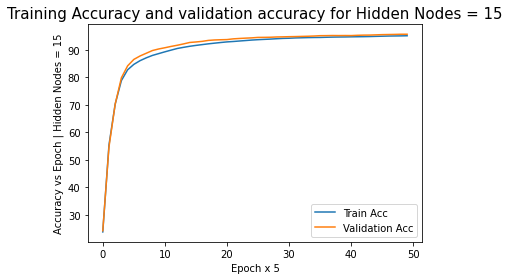

In [22]:
plt.plot(range(len(nn_1.train_acc)),nn_1.train_acc,nn_1.val_acc)
plt.title("Training Accuracy and validation accuracy for Hidden Nodes = 15",fontsize=15)
plt.legend(["Train Acc", "Validation Acc"])
plt.xlabel("Epoch x 5")
plt.ylabel("Accuracy vs Epoch | Hidden Nodes = 15")

Text(0, 0.5, 'Cost vs Epoch | Hidden Nodes = 15')

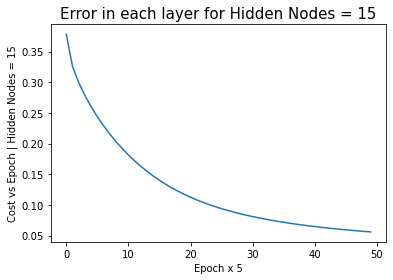

In [23]:
plt.plot(range(len(nn_1.train_acc)),nn_1.train_cost)
plt.title("Error in each layer for Hidden Nodes = 15",fontsize=15)
plt.xlabel("Epoch x 5")
plt.ylabel("Cost vs Epoch | Hidden Nodes = 15")

We can observe from the accuracy graphs that the training and validation accuracies are increasing with the increase in the number of epochs and the error is decreasing with the number of epochs. 